In [1]:
library(tidyverse)
library(magrittr)
library(reshape2)
library(multcomp)
library(rstatix)
library(lmerTest)
library(readxl)
library(ggpubr)
library(nlme)
library(lme4)

── Attaching core tidyverse packages ──────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package:

In [2]:
CHNS_raw <- readxl::read_xlsx("CHNS_Dataset_SM&INT.xlsx")

In [3]:
str(CHNS_raw)

tibble [81 × 17] (S3: tbl_df/tbl/data.frame)
 $ Tray_Number   : chr [1:81] "Tiaan Tray1 A1" "Tiaan Tray1 A2" "Tiaan Tray1 A3" "Tiaan Tray1 A4" ...
 $ Sample_ID     : chr [1:81] "SM1-T1-D5" "SM1-T1-D3" "SM1-T1-D1" "SM1-T1-D0.5" ...
 $ Habitat       : chr [1:81] "Saltmarsh" "Saltmarsh" "Saltmarsh" "Saltmarsh" ...
 $ Veg           : chr [1:81] "Saltmarsh" "Saltmarsh" "Saltmarsh" "Saltmarsh" ...
 $ Site          : chr [1:81] "Upper" "Upper" "Upper" "Upper" ...
 $ Transect      : chr [1:81] "T1" "T1" "T1" "T1" ...
 $ Distance      : num [1:81] 5 3 1 0.5 0 5 3 1 0.5 0 ...
 $ Number        : num [1:81] 1 2 3 4 5 6 7 8 9 10 ...
 $ Weight_mg     : num [1:81] 81.2 61.1 60.9 68.1 64.4 ...
 $ N_percent     : num [1:81] 0.66 0.55 0.48 0.42 0.32 0.66 0.94 0.51 0.43 0.41 ...
 $ C_percent     : num [1:81] 5.82 4.83 3.82 3.3 1.97 5.22 8.79 3.89 3.24 2.36 ...
 $ H_percent     : num [1:81] 1.53 1.59 1.43 1.6 1.14 ...
 $ S_percent     : num [1:81] 0.177 0.195 0.146 0.12 0.066 0.187 0.26 0.147 0.214 0.109 

In [4]:
xtabs(~ Habitat + Transect + Site , data = CHNS_raw)

, , Site = Lower

           Transect
Habitat     T1 T2 T3
  Saltmarsh  5  5  5
  Seagrass   4  4  4

, , Site = Middle

           Transect
Habitat     T1 T2 T3
  Saltmarsh  5  5  5
  Seagrass   4  4  4

, , Site = Upper

           Transect
Habitat     T1 T2 T3
  Saltmarsh  5  5  5
  Seagrass   4  4  4


In [5]:
CHNS_Dataset <- CHNS_raw |>
                dplyr::mutate(DBD = Dry_mass / Volume ) |>
                dplyr::mutate_if(is.character, factor) |>
                dplyr::mutate(log_C_percent = log(C_percent)) |>
                dplyr::arrange(Habitat, Veg, Site, Transect, Distance) 
str(CHNS_Dataset)

tibble [81 × 19] (S3: tbl_df/tbl/data.frame)
 $ Tray_Number   : Factor w/ 81 levels "Tiaan Tray1 A1",..: 27 26 25 35 34 40 39 38 37 36 ...
 $ Sample_ID     : Factor w/ 81 levels "INT1-T1-D0.5",..: 67 68 69 70 71 72 73 74 75 76 ...
 $ Habitat       : Factor w/ 2 levels "Saltmarsh","Seagrass": 1 1 1 1 1 1 1 1 1 1 ...
 $ Veg           : Factor w/ 2 levels "IntertidalSeagrass",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Site          : Factor w/ 3 levels "Lower","Middle",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Transect      : Factor w/ 3 levels "T1","T2","T3": 1 1 1 1 1 2 2 2 2 2 ...
 $ Distance      : num [1:81] 0 0.5 1 3 5 0 0.5 1 3 5 ...
 $ Number        : num [1:81] 35 34 33 32 31 40 39 38 37 36 ...
 $ Weight_mg     : num [1:81] 64.7 62.8 61.9 62.7 61.4 ...
 $ N_percent     : num [1:81] 0.22 0.09 0.14 0.09 0.24 0.09 0.09 0.07 0.13 0.08 ...
 $ C_percent     : num [1:81] 1.55 0.48 0.94 0.47 1.83 0.57 0.44 0.41 1.18 0.73 ...
 $ H_percent     : num [1:81] 0.754 0.413 0.57 0.367 0.77 0.459 0.362 0.307 0.648 0.35

In [6]:
#Get some summary statistics
CHNS_Dataset |>
             dplyr::group_by(Site, Habitat) |>
             rstatix::get_summary_stats(C_percent, type = "mean_sd") |>
             dplyr::arrange(Habitat, Site)

Habitat,Site,variable,n,mean,sd
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
Saltmarsh,Lower,C_percent,15,0.775,0.436
Saltmarsh,Middle,C_percent,15,7.196,4.970
Saltmarsh,Upper,C_percent,15,4.255,2.150
Seagrass,Lower,C_percent,12,0.511,0.312
Seagrass,Middle,C_percent,12,0.311,0.172
Seagrass,Upper,C_percent,12,0.915,0.334


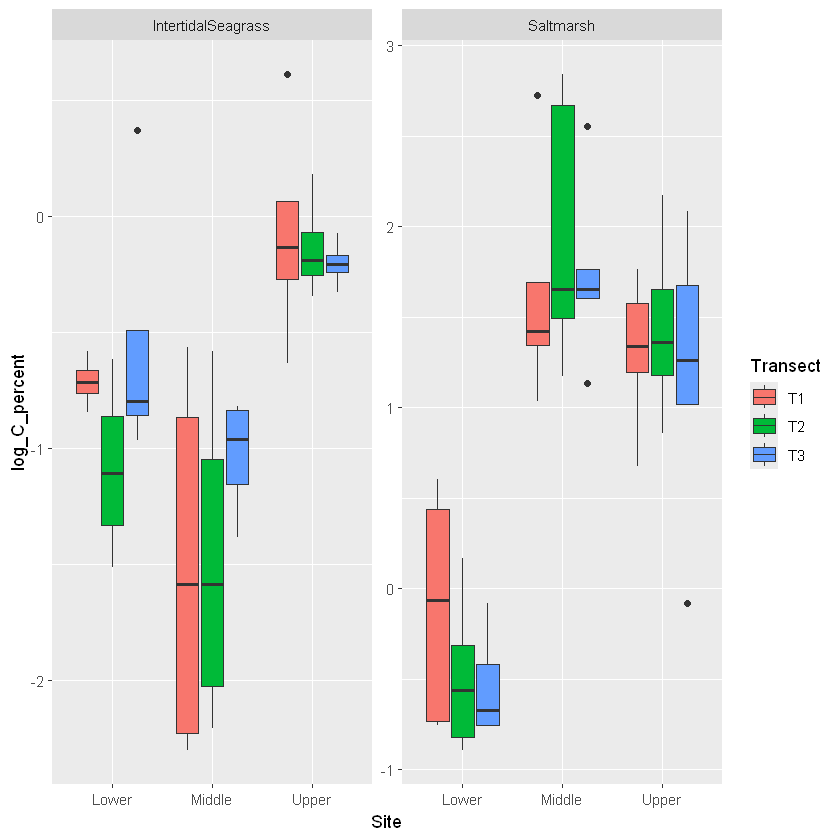

In [7]:
#https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/
CHNS_Dataset |>
             ggplot(aes(x = Site,  y = log_C_percent, fill = Transect)) + 
             geom_boxplot() +
             facet_wrap(~Veg, scale = "free")

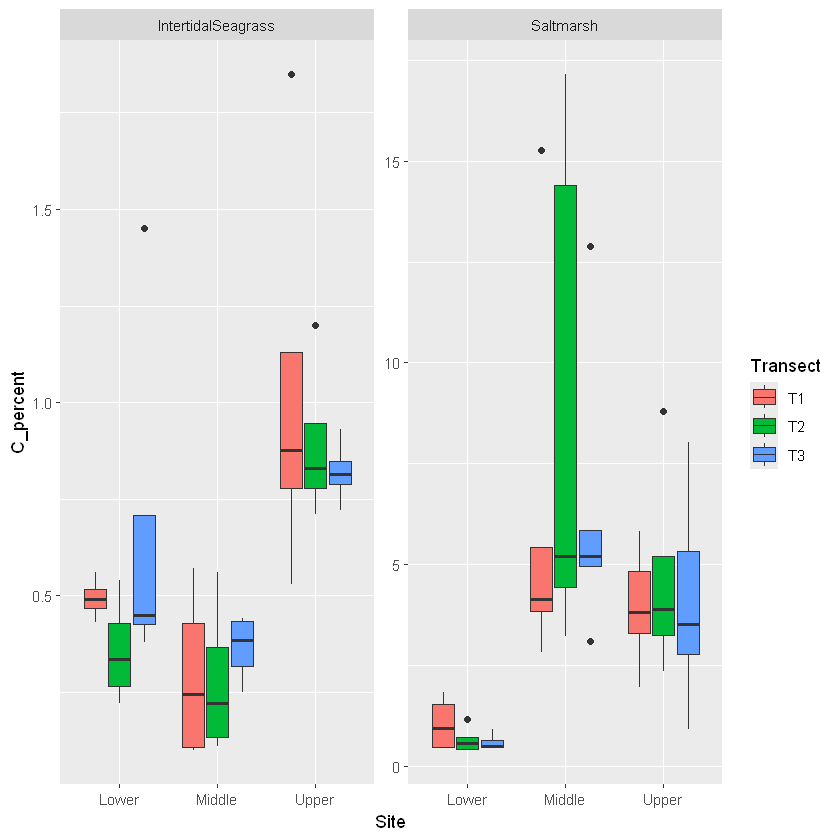

In [8]:
#https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/
CHNS_Dataset |>
             ggplot(aes(x = Site,  y = C_percent, fill = Transect)) + 
             geom_boxplot() +
             facet_wrap(~Veg, scale = "free")

In [9]:
#Check for outliers
CHNS_Dataset %>%
             dplyr::select(Habitat, Site, log_C_percent) %>%
             dplyr::group_by(Habitat, Site) %>%
             rstatix::identify_outliers(log_C_percent)

Habitat,Site,log_C_percent,is.outlier,is.extreme
<fct>,<fct>,<dbl>,<lgl>,<lgl>
Saltmarsh,Upper,-0.08338161,TRUE,FALSE
Seagrass,Lower,-1.51412773,TRUE,FALSE
Seagrass,Lower,0.37156356,TRUE,TRUE
Seagrass,Upper,0.61518564,TRUE,TRUE
Seagrass,Upper,-0.63487827,TRUE,FALSE
Seagrass,Upper,0.18232156,TRUE,FALSE


In [10]:
#Check for outliers
CHNS_Dataset %>%
             dplyr::select(Habitat, Site, C_percent) %>%
             dplyr::group_by(Habitat, Site) %>%
             rstatix::identify_outliers(C_percent)

Habitat,Site,C_percent,is.outlier,is.extreme
<fct>,<fct>,<dbl>,<lgl>,<lgl>
Saltmarsh,Lower,1.83,TRUE,FALSE
Saltmarsh,Upper,8.79,TRUE,FALSE
Seagrass,Lower,1.45,TRUE,TRUE
Seagrass,Upper,1.85,TRUE,TRUE
Seagrass,Upper,0.53,TRUE,FALSE
Seagrass,Upper,1.20,TRUE,FALSE


In [11]:
#Normality assumption
CHNS_Dataset |>
             dplyr::select(Habitat, Site, log_C_percent) %>%
             dplyr::group_by(Habitat, Site) %>%
             rstatix::shapiro_test(log_C_percent) %>%
             dplyr::arrange(Habitat, Site)

Habitat,Site,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
Saltmarsh,Lower,log_C_percent,0.8735026,0.03799578
Saltmarsh,Middle,log_C_percent,0.8624123,0.02615069
Saltmarsh,Upper,log_C_percent,0.9520008,0.55649884
Seagrass,Lower,log_C_percent,0.8657800,0.05779063
Seagrass,Middle,log_C_percent,0.8763206,0.07864624
Seagrass,Upper,log_C_percent,0.8748087,0.07522960


In [12]:
#Normality assumption
CHNS_Dataset |>
             dplyr::select(Habitat, Site, C_percent) %>%
             dplyr::group_by(Habitat, Site) %>%
             rstatix::shapiro_test(C_percent) 

Habitat,Site,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
Saltmarsh,Lower,C_percent,0.7924019,0.002941935
Saltmarsh,Middle,C_percent,0.7595985,0.001165974
Saltmarsh,Upper,C_percent,0.9459749,0.463427641
Seagrass,Lower,C_percent,0.6386589,0.000229833
Seagrass,Middle,C_percent,0.9125127,0.229745200
Seagrass,Upper,C_percent,0.7451202,0.002377674


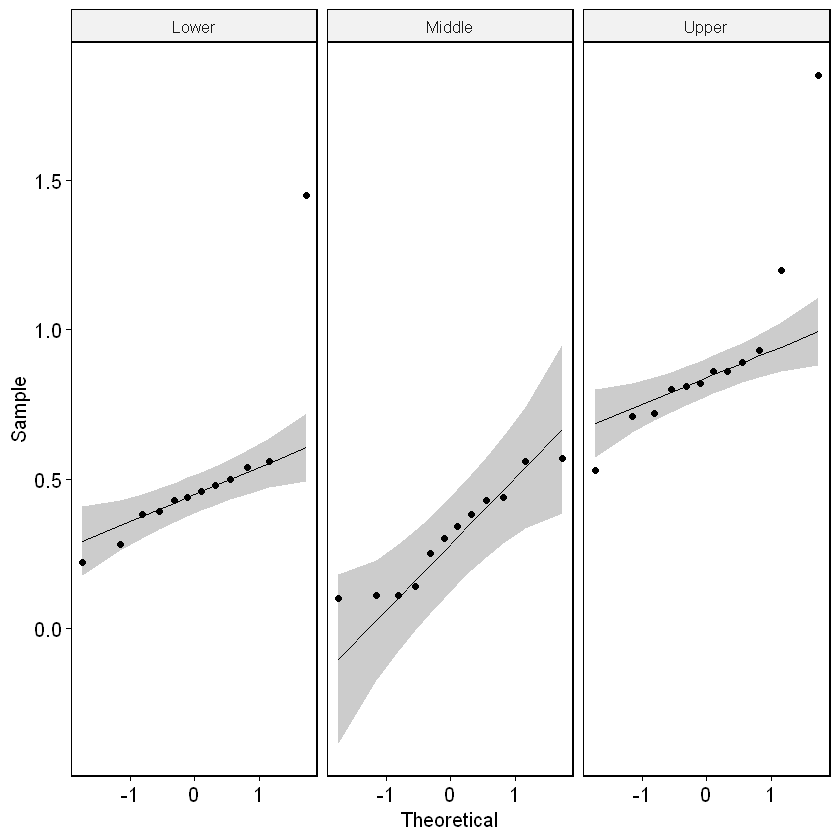

In [13]:
#Normality assumption by visiual inspection
#QQ plot draws the correlation between a given data and the normal distribution.
CHNS_Dataset %>%
             dplyr::filter(Habitat == "Seagrass") %>%
             ggqqplot(data = . , x = "C_percent", facet.by = c("Site"))

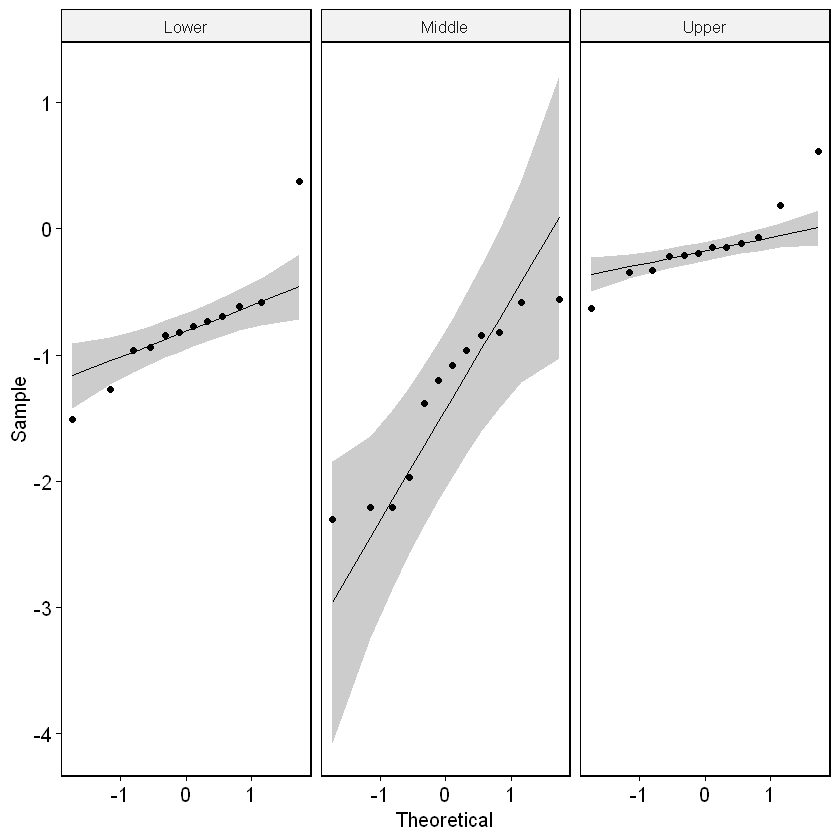

In [14]:
#Normality assumption by visiual inspection
#QQ plot draws the correlation between a given data and the normal distribution.
CHNS_Dataset %>%
             dplyr::filter(Habitat == "Seagrass") %>%
             ggqqplot(data = . , x = "log_C_percent", facet.by = c("Site"))

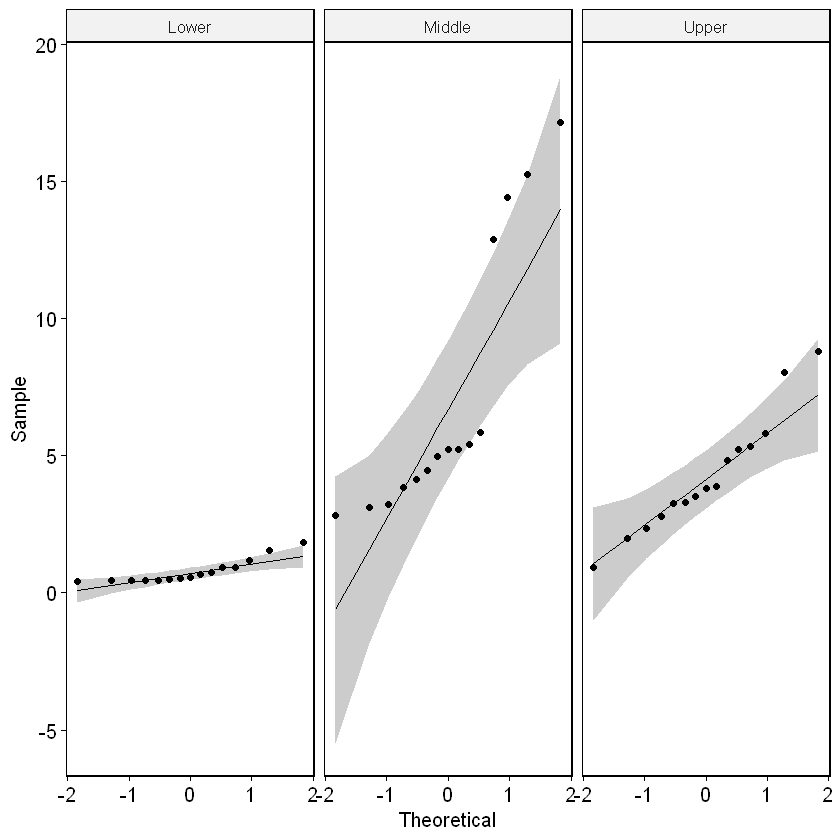

In [15]:
CHNS_Dataset %>%
             dplyr::filter(Habitat == "Saltmarsh") %>%
             ggqqplot(data = . , x = "C_percent", facet.by = c("Site"))

In [16]:
#Add a column for unique names in transects
#Always good to check if identical labels habe any effiect on your model
CHNS_Dataset  %<>% dplyr::mutate(transect_ref = paste (Site, Transect, sep = "_"))

In [17]:
Seagrass  <-  CHNS_Dataset %>%  
              dplyr::filter(Habitat == "Seagrass")
Saltmarsh <-  CHNS_Dataset %>%  
              dplyr::filter(Habitat == "Saltmarsh")

In [18]:
xtabs(~ Site + Transect, data = Seagrass)

        Transect
Site     T1 T2 T3
  Lower   4  4  4
  Middle  4  4  4
  Upper   4  4  4

In [19]:
str(Seagrass)

tibble [36 × 20] (S3: tbl_df/tbl/data.frame)
 $ Tray_Number   : Factor w/ 81 levels "Tiaan Tray1 A1",..: 76 75 74 70 80 79 78 77 81 73 ...
 $ Sample_ID     : Factor w/ 81 levels "INT1-T1-D0.5",..: 25 26 27 28 29 30 31 32 33 34 ...
 $ Habitat       : Factor w/ 2 levels "Saltmarsh","Seagrass": 2 2 2 2 2 2 2 2 2 2 ...
 $ Veg           : Factor w/ 2 levels "IntertidalSeagrass",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Site          : Factor w/ 3 levels "Lower","Middle",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Transect      : Factor w/ 3 levels "T1","T2","T3": 1 1 1 1 2 2 2 2 3 3 ...
 $ Distance      : num [1:36] 0.5 1 3 5 0.5 1 3 5 0.5 1 ...
 $ Number        : num [1:36] 73 72 71 70 77 76 75 74 81 80 ...
 $ Weight_mg     : num [1:36] 61.1 61.4 61.1 60.2 62 ...
 $ N_percent     : num [1:36] 0.08 0.09 0.07 0.06 0.04 0.04 0.06 0.07 0.07 0.06 ...
 $ C_percent     : num [1:36] 0.56 0.5 0.43 0.48 0.28 0.22 0.39 0.54 0.46 0.38 ...
 $ H_percent     : num [1:36] 0.337 0.315 0.289 0.251 0.194 0.171 0.273 0.331 0.278 0.2

In [20]:
(lmer_fit <- lmer(C_percent ~ Site + N_percent + Distance + (1|Site:Transect), data = Seagrass))
summary(lmer_fit)

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: C_percent ~ Site + N_percent + Distance + (1 | Site:Transect)
   Data: Seagrass
REML criterion at convergence: -4.1947
Random effects:
 Groups        Name        Std.Dev.
 Site:Transect (Intercept) 0.0700  
 Residual                  0.1882  
Number of obs: 36, groups:  Site:Transect, 9
Fixed Effects:
(Intercept)   SiteMiddle    SiteUpper    N_percent     Distance  
    0.04153     -0.11703     -0.35360      6.63734     -0.01666  

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: C_percent ~ Site + N_percent + Distance + (1 | Site:Transect)
   Data: Seagrass

REML criterion at convergence: -4.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6023 -0.3967 -0.0815  0.2473  4.0577 

Random effects:
 Groups        Name        Variance Std.Dev.
 Site:Transect (Intercept) 0.00490  0.0700  
 Residual                  0.03542  0.1882  
Number of obs: 36, groups:  Site:Transect, 9

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.04153    0.10836 20.91810   0.383   0.7054    
SiteMiddle  -0.11703    0.09666  5.79537  -1.211   0.2730    
SiteUpper   -0.35360    0.15381 20.00289  -2.299   0.0324 *  
N_percent    6.63734    1.05435 30.43952   6.295 5.75e-07 ***
Distance    -0.01666    0.01788 25.08573  -0.932   0.3604    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
   

In [21]:
#https://mspeekenbrink.github.io/sdam-r-companion/linear-mixed-effects-models.html
(lmer_log_fit <- lmer(log_C_percent ~ Site + N_percent + Distance + (1|Site:Transect), data = Seagrass))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: log_C_percent ~ Site + N_percent + Distance + (1 | Site:Transect)
   Data: Seagrass
REML criterion at convergence: 34.2952
Random effects:
 Groups        Name        Std.Dev.
 Site:Transect (Intercept) 0.04621 
 Residual                  0.36279 
Number of obs: 36, groups:  Site:Transect, 9
Fixed Effects:
(Intercept)   SiteMiddle    SiteUpper    N_percent     Distance  
   -1.64357     -0.44170     -0.44730      9.58062      0.05331  

In [22]:
summary(lmer_fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: C_percent ~ Site + N_percent + Distance + (1 | Site:Transect)
   Data: Seagrass

REML criterion at convergence: -4.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6023 -0.3967 -0.0815  0.2473  4.0577 

Random effects:
 Groups        Name        Variance Std.Dev.
 Site:Transect (Intercept) 0.00490  0.0700  
 Residual                  0.03542  0.1882  
Number of obs: 36, groups:  Site:Transect, 9

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.04153    0.10836 20.91810   0.383   0.7054    
SiteMiddle  -0.11703    0.09666  5.79537  -1.211   0.2730    
SiteUpper   -0.35360    0.15381 20.00289  -2.299   0.0324 *  
N_percent    6.63734    1.05435 30.43952   6.295 5.75e-07 ***
Distance    -0.01666    0.01788 25.08573  -0.932   0.3604    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
   

In [23]:
(post_hoc <- multcomp::glht(lmer_log_fit, linfct = mcp(Site = 'Tukey')))
summary(post_hoc)


	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                     Estimate
Middle - Lower == 0 -0.441698
Upper - Lower == 0  -0.447297
Upper - Middle == 0 -0.005598



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = log_C_percent ~ Site + N_percent + Distance + 
    (1 | Site:Transect), data = Seagrass)

Linear Hypotheses:
                     Estimate Std. Error z value Pr(>|z|)  
Middle - Lower == 0 -0.441698   0.154814  -2.853   0.0112 *
Upper - Lower == 0  -0.447297   0.272055  -1.644   0.2168  
Upper - Middle == 0 -0.005598   0.292768  -0.019   0.9998  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
(Adjusted p values reported -- single-step method)


In [24]:
(lmer_fit_sm <- lmer(log_C_percent ~ Site + N_percent + Distance + (1|Transect), data = Saltmarsh))

Linear mixed model fit by REML ['lmerModLmerTest']
Formula: log_C_percent ~ Site + N_percent + Distance + (1 | Transect)
   Data: Saltmarsh
REML criterion at convergence: 29.648
Random effects:
 Groups   Name        Std.Dev.
 Transect (Intercept) 0.06821 
 Residual             0.28718 
Number of obs: 45, groups:  Transect, 3
Fixed Effects:
(Intercept)   SiteMiddle    SiteUpper    N_percent     Distance  
   -0.69077      1.15674      1.10901      1.33246      0.08615  

In [25]:
summary(lmer_fit_sm)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_C_percent ~ Site + N_percent + Distance + (1 | Transect)
   Data: Saltmarsh

REML criterion at convergence: 29.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.60209 -0.52494 -0.02925  0.55511  2.72863 

Random effects:
 Groups   Name        Variance Std.Dev.
 Transect (Intercept) 0.004652 0.06821 
 Residual             0.082472 0.28718 
Number of obs: 45, groups:  Transect, 3

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept) -0.69077    0.09587 12.65304  -7.206 8.02e-06 ***
SiteMiddle   1.15674    0.14442 38.58839   8.009 9.92e-10 ***
SiteUpper    1.10901    0.11961 38.30657   9.272 2.48e-11 ***
N_percent    1.33246    0.13217 39.12232  10.081 1.96e-12 ***
Distance     0.08615    0.02308 38.01585   3.732 0.000619 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           (I